<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_1_LatentSpace_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# amp: automatic mixed precision.
#      provides convenience methods for mixed precision, where some operations use the torch.float32 (float) datatype
#      and other operations use lower precision floating point datatype (lower_precision_fp): torch.float16 (half) or
#      torch.bfloat16. Some ops, like linear layers and convolutions, are much faster in lower_precision_fp. Other ops,
#      like reductions, often require the dynamic range of float32. Mixed precision tries to match each op to its
#      appropriate datatype, which can reduce your network’s runtime and memory footprint.
#      Ordinarily, “automatic mixed precision training” uses torch.autocast and torch.cuda.amp.GradScaler together.

 The `Autoencoder` class inherits from `nn.Module`, a base class for all neural network modules in PyTorch. Here's a breakdown of the code and its functionality:

### Initialization Method (`__init__`)
- **Parameters**: The `__init__` method accepts a single parameter `encoding_dim`, which specifies the size of the latent space where the input data is compressed.
- **Encoder**: The encoder part of the autoencoder is designed to compress the input data (in this case, an image) into a lower-dimensional representation called the latent space. It consists of a sequence of layers:
  - `nn.Linear(28 * 28, 128)`: This layer flattens the input image (assumed to be 28x28 pixels, typical for MNIST dataset images) into a one-dimensional array and performs a linear transformation to reduce its dimension to 128.
  - `nn.ReLU(True)`: A Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity, helping the model learn complex patterns.
  - Another `nn.Linear(128, encoding_dim)`: Further reduces the dimension from 128 to the specified `encoding_dim`.
  - Another `nn.ReLU(True)`: Another ReLU activation for non-linearity.
- **Decoder**: The decoder part reconstructs the original input data from the compressed representation. It mirrors the encoder structure but in reverse, aiming to expand the compressed data back to its original shape:
  - `nn.Linear(encoding_dim, 128)`: Expands the compressed data from `encoding_dim` back to 128.
  - `nn.ReLU(True)`: Applies ReLU activation.
  - `nn.Linear(128, 28 * 28)`: Transforms the data from 128 back to the flattened image size of 784 (28x28).
  - `nn.Sigmoid()`: Applies a sigmoid activation function to ensure the output values are between 0 and 1, suitable for image data where pixel values typically fall within this range.

### Forward Method (`forward`)
- **Parameter**: The `forward` method defines how the input `x` flows through the network.
- **Process**:
  - `x.view(-1, 28*28)`: First, the input `x` is reshaped into a one-dimensional array (flattened) if not already done.
  - `self.encoder(x)`: The flattened `x` is then passed through the encoder.
  - `self.decoder(x)`: The output from the encoder, which is the compressed representation, is fed into the decoder.
- **Output**: The final output is reshaped back to the original image dimensions (`-1, 1, 28, 28`), where `-1` is a placeholder that automatically adjusts based on the batch size.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),       # Flatten the image and then linearly transform it
            nn.ReLU(True),                 # Non-linear activation function
            nn.Linear(128, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)                  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Linearly transforms the encoding
            nn.ReLU(True),                 # Non-linear activation function
            nn.Linear(128, 28 * 28),       # Transforms back to original image shape
            nn.Sigmoid()                   # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))   # Encode the input image
        x = self.decoder(x)                   # Decode the encoded image
        return x.view(-1, 1, 28, 28)          # Reshape to the original image dimensions

In [ ]:

def imshow(img):
    img = img.cpu() / 2 + 0.5                    # Unnormalize the image
    npimg = img.numpy()                          # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))   # Reshape and display the image
    plt.show()

In [ ]:
# Transform: converts images to PyTorch tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#==========================================================
# 1. torchvision.transforms: a class that provides common image transformations. They can be chained together using Compose.
# 1. torchvision.transforms.Compose(): composes several transforms together.
# 2. torchvision.transforms.Normalize((): Normalize a tensor image with mean and standard deviation.
#==========================================================

In [ ]:
# MNIST dataset loading
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 36132840.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1124270.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9776230.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 8190253.12it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # torch.device select the device on which a torch.Tensor is or will be sent to.
model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()                                                # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)               # Optimizer

In [ ]:
# Training loop
num_epochs = 2
scaler = GradScaler()

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast():
            output = model(img)
            loss = criterion(output, img)

        optimizer.zero_grad()           # clears existing gradients from the last step (otherwise you’d just accumulate the next computed gradients from all loss.backward() calls)
        scaler.scale(loss).backward()   # computes the gradients w.r.t. the parameters (or anything requiring gradients) using backpropagation..--> loss.backward()
        scaler.step(optimizer)          # call optimizer one time to update weights based on the gradients of the parameters. 2) should not modify the .grad field of the parameters. -->optimizer.step()
        scaler.update()
    print(img)
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

# ==================================================================================================
# 1. torch.cuda.amp.autocast(): serve as context managers or decorators that allow the subsequent regions of scripts to run in mixed precision.
#    With in the region, ops run in an op-specific dtype chosen by autocast to improve performance while maintaining accuracy.
# 2. torch.cuda.amp.GradScaler(): If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients.
#    Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”),
#    so the update for the corresponding parameters will be lost.
#    To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass
#    on the scaled loss(es). In other words, gradient values have a larger magnitude, so they don’t flush to zero.
#    Each parameter’s gradient (.grad attribute) should be unscaled before the optimizer updates the parameters, so the scale
#    factor does not interfere with the learning rate.
# ==================================================================================================

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

Original Images


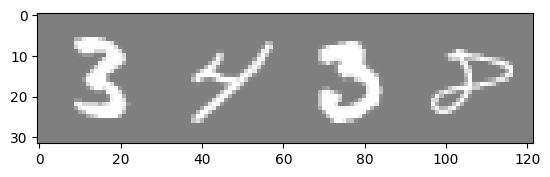

Original Representation
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1.

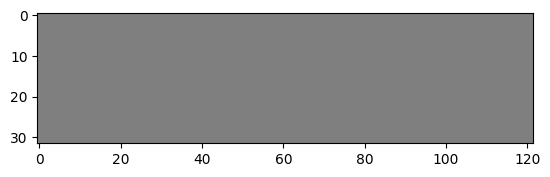

In [ ]:
# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:4], normalize=True))

# Encoded and decoded images
with torch.no_grad():
    encoded_imgs = model.encoder(images.view(-1, 28*28)[:4])
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)


# Display reconstructed images
print("Original Representation")
print(img)

# Print latent space
print("Latent space representations:")
print(encoded_imgs.shape)

print("Decode representations:")
print(decoded_imgs.shape)
imshow(vutils.make_grid(decoded_imgs, normalize=True))